# Hourly Energy Consumption Forecasting (Advanced Techniques)

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

### Importing Dataset as Pandas DataFrame

In [2]:
df = pd.read_csv("data.csv")

### About Dataset
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

``PJM East Region: 2001-2018 (PJME)``

- estimated energy consumption in Megawatts (MW)

### EDA

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df = df.set_index('Datetime')

In [5]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [6]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [7]:
df.shape

(145366, 1)

In [8]:
round(df.describe(),2)

,PJME_MW
count,145366.00
mean,32080.22
std,6464.01
min,14544.00
25%,27573.00
50%,31421.00
75%,35650.00
max,62009.00


In [9]:
df.index.dtype

dtype('O')

In [10]:
df.index = pd.to_datetime(df.index)

In [11]:
df.index.dtype

dtype('<M8[ns]')

In [12]:
color_pal = sns.color_palette()

Text(0, 0.5, 'Hourly Energy Consumption (MW)')

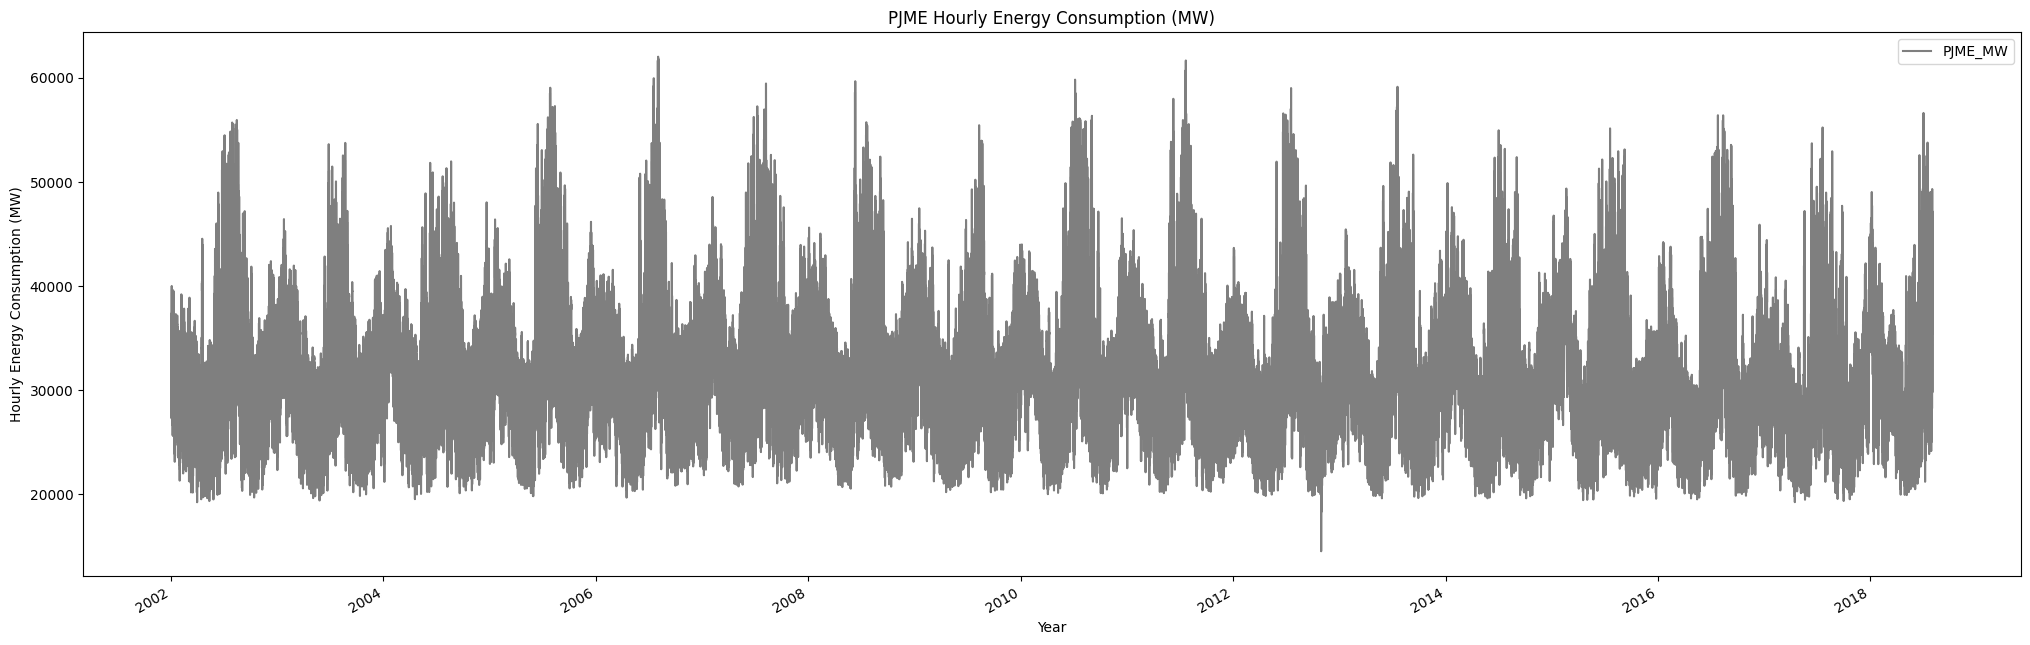

In [13]:
df.plot(figsize=(25,8),title="PJME Hourly Energy Consumption (MW)",color=color_pal[7])
plt.xlabel("Year")
plt.ylabel("Hourly Energy Consumption (MW)")

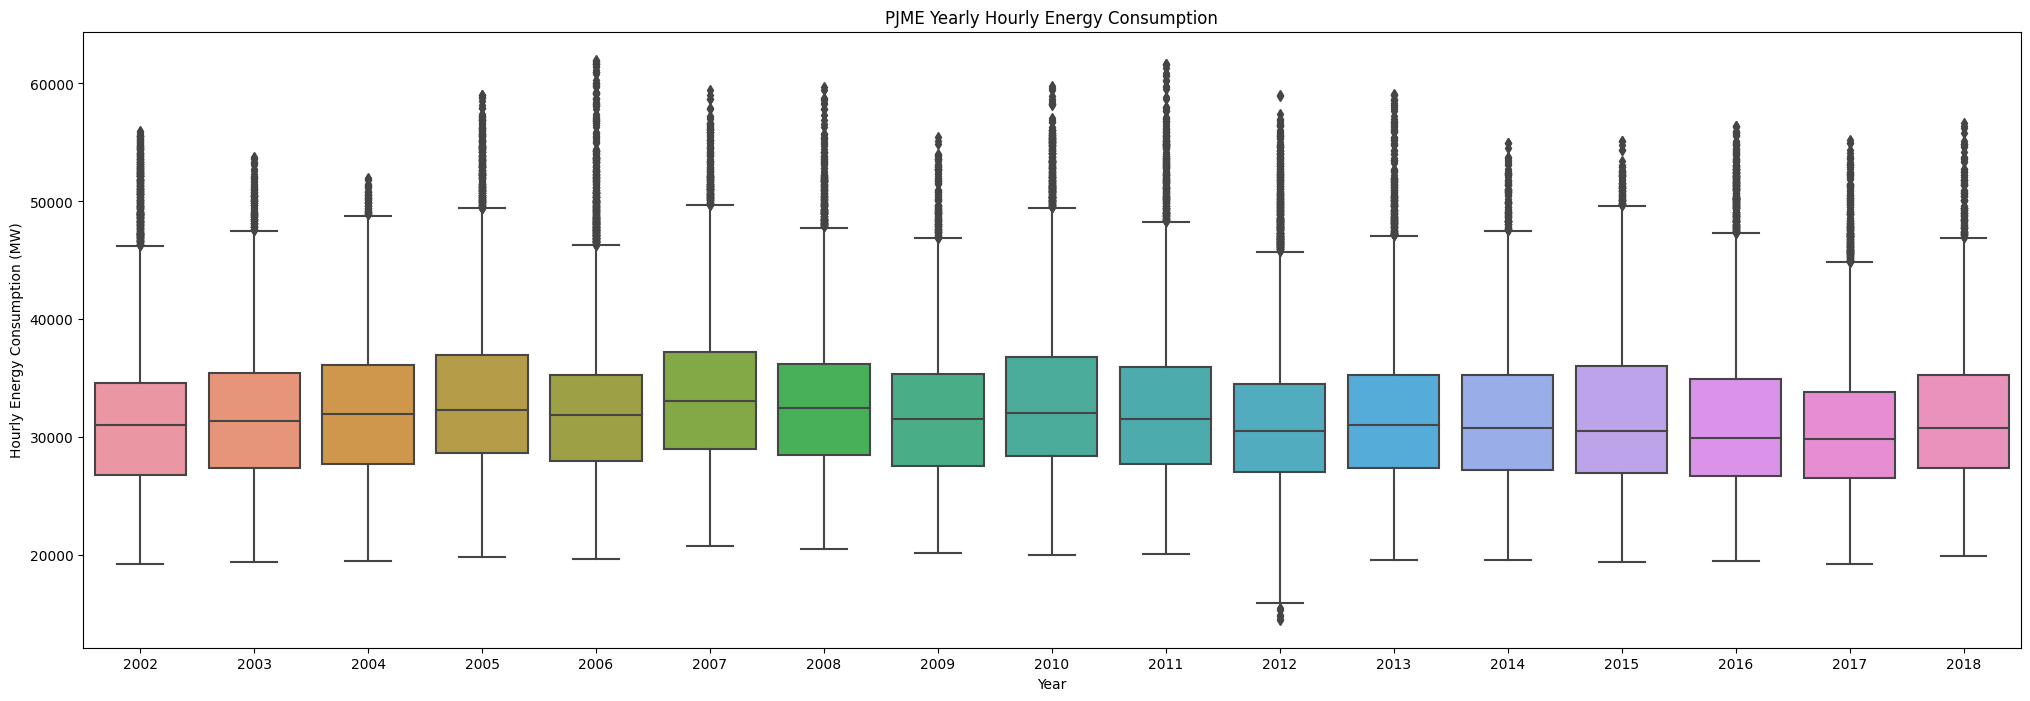

In [14]:
_,ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.year,y = df['PJME_MW'].values,ax=ax)
plt.title("PJME Yearly Hourly Energy Consumption")
plt.xlabel("Year")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.show()

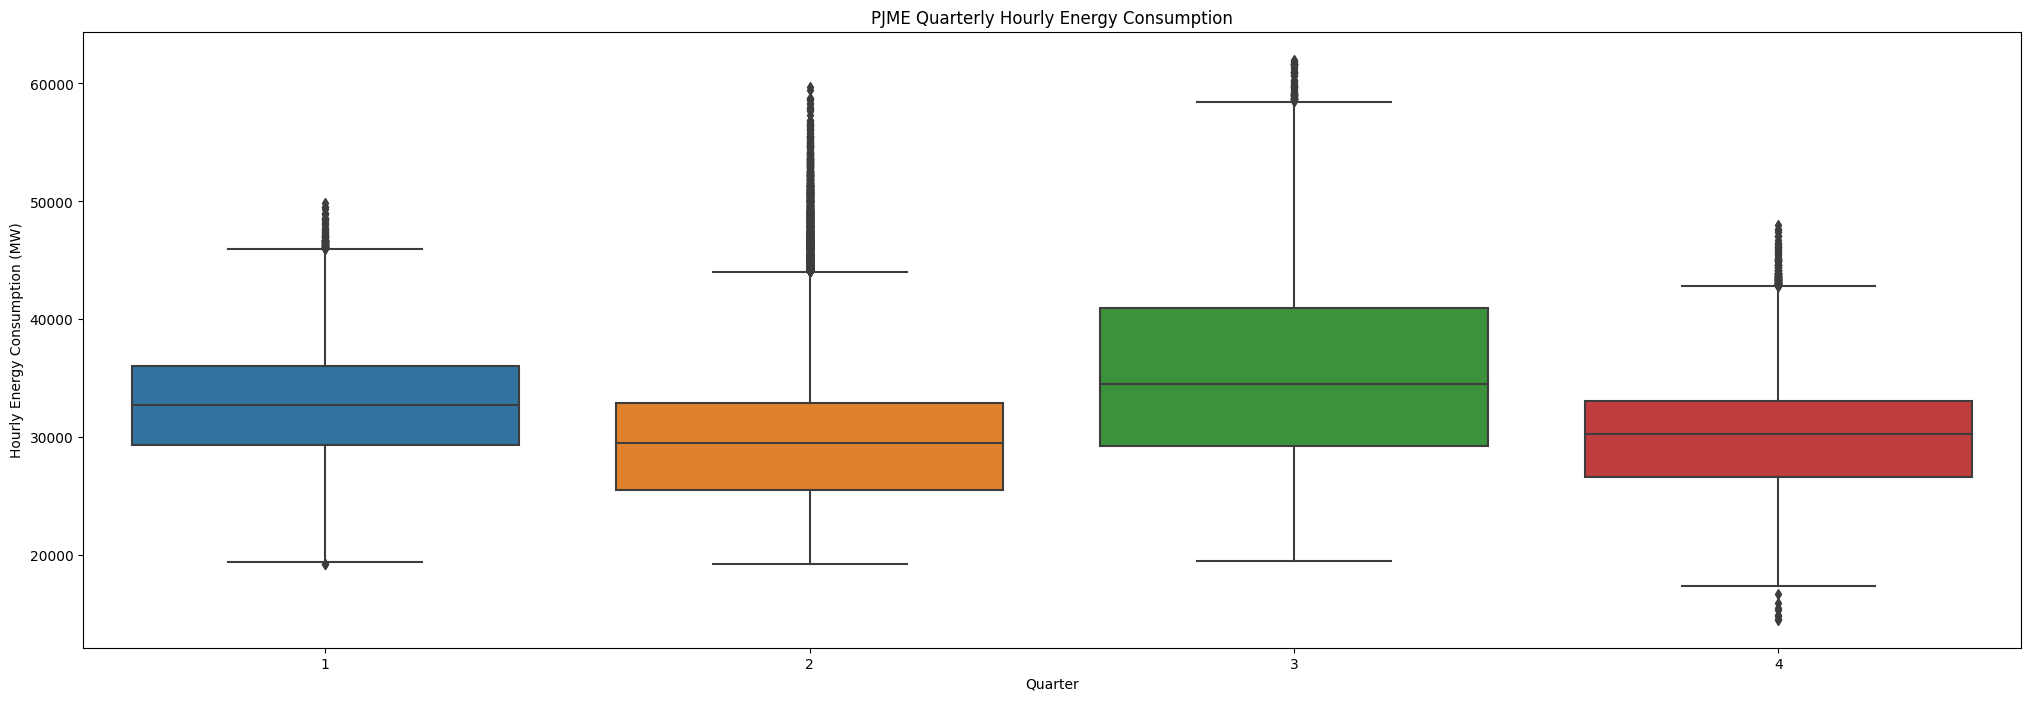

In [15]:
_,ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.quarter,y = df['PJME_MW'].values,ax=ax)
plt.title("PJME Quarterly Hourly Energy Consumption")
plt.xlabel("Quarter")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.show()

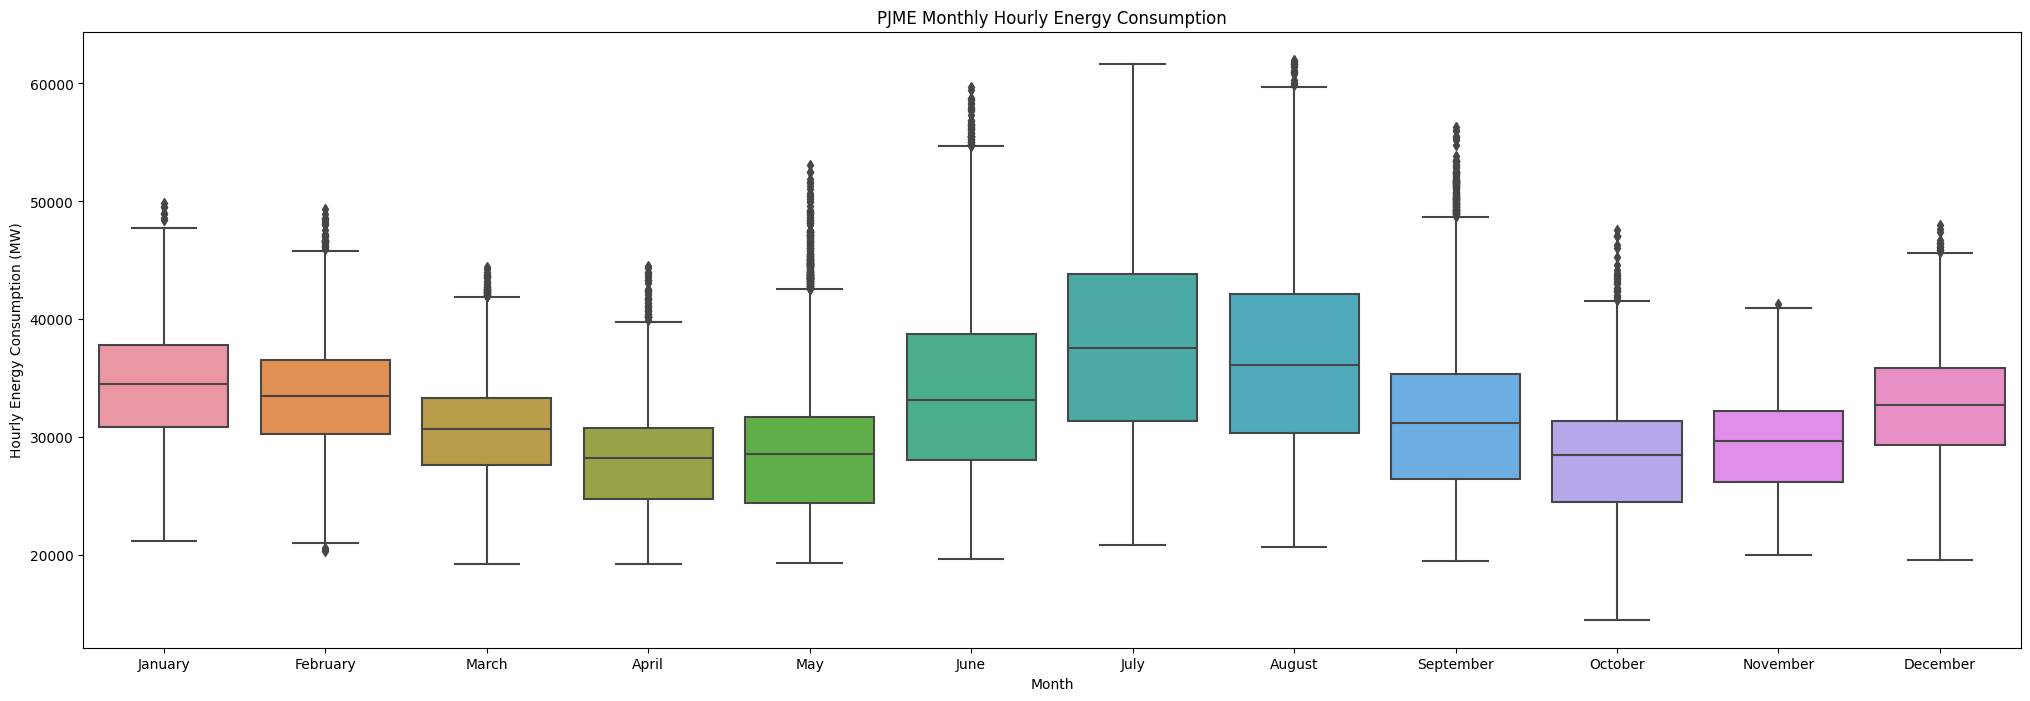

In [16]:
_,ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.month_name(),
            y = df['PJME_MW'].values,
            ax=ax,
            order = ['January', 'February', 'March', 'April', 'May', 'June',
                     'July', 'August', 'September', 'October', 'November', 'December'])
plt.title("PJME Monthly Hourly Energy Consumption")
plt.xlabel("Month")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.show()

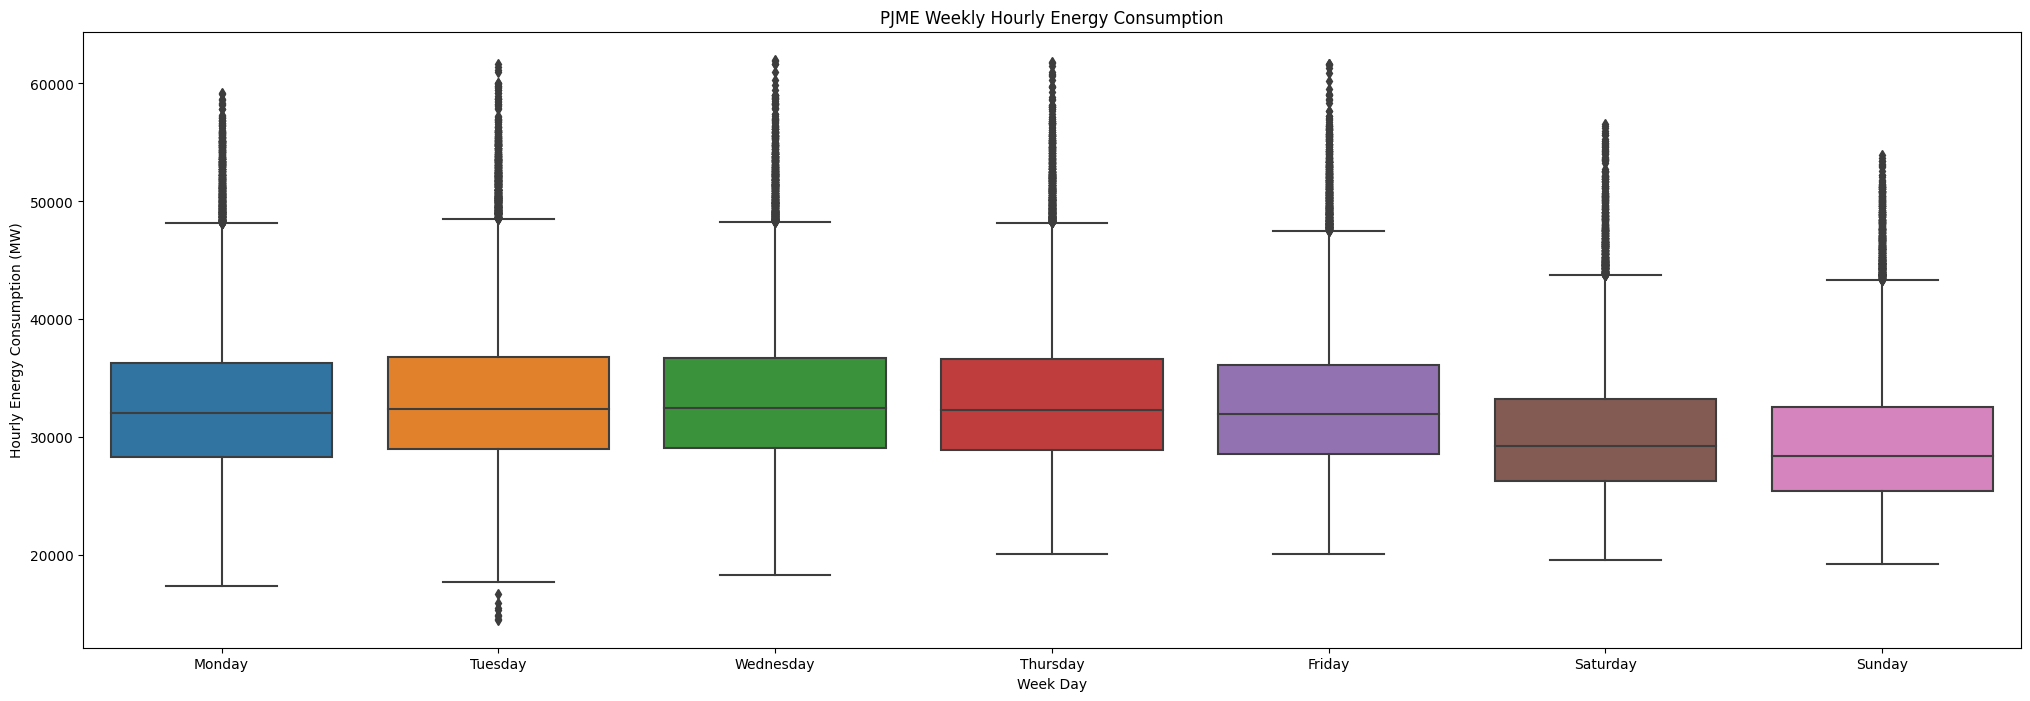

In [17]:
_,ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.day_name(),
            y = df['PJME_MW'].values,
            ax=ax,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("PJME Weekly Hourly Energy Consumption")
plt.xlabel("Week Day")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.show()

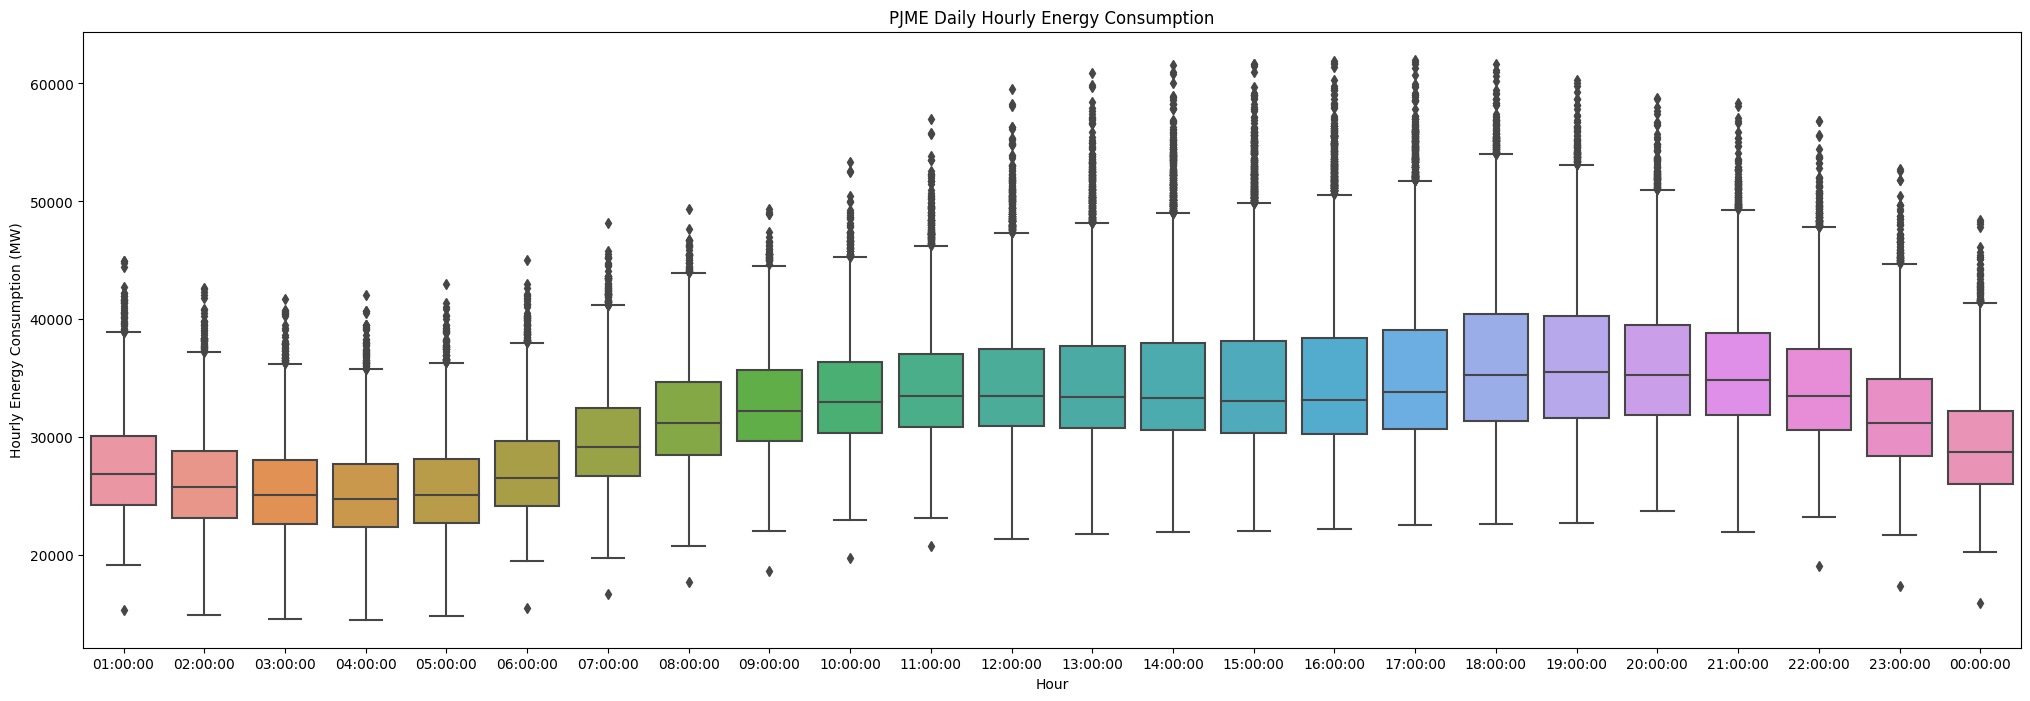

In [18]:
_,ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.time,y = df['PJME_MW'].values,ax=ax)
plt.title("PJME Daily Hourly Energy Consumption")
plt.xlabel("Hour")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.show()

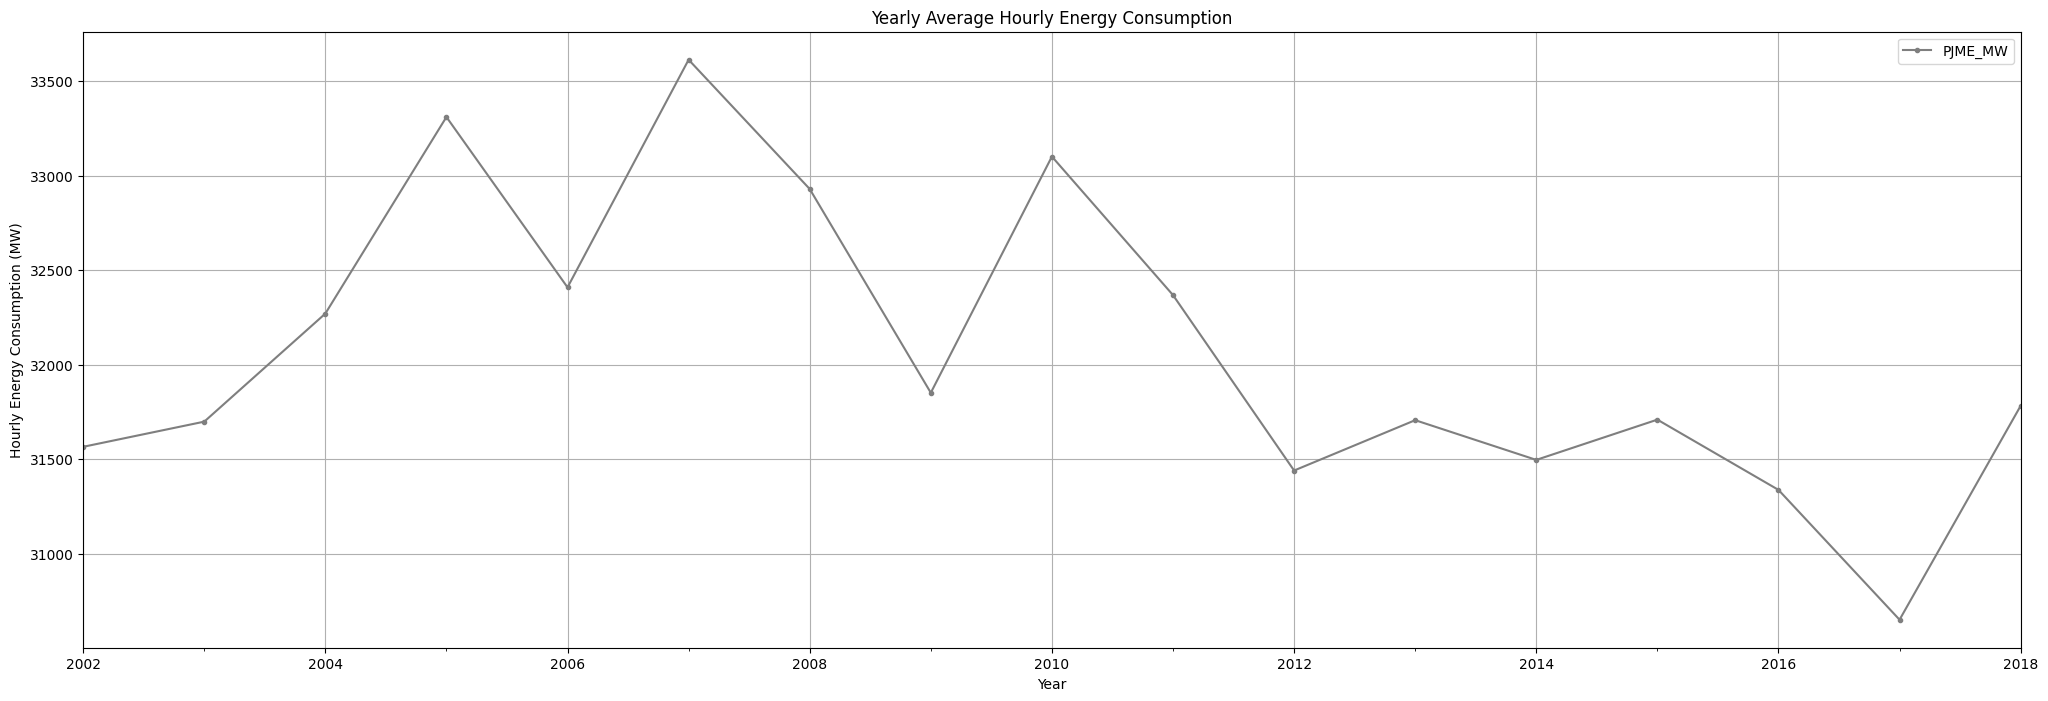

In [19]:
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot(figsize=(25,8),color=color_pal[7],marker=".")
plt.title("Yearly Average Hourly Energy Consumption")
plt.xlabel("Year")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.grid()

### Outlier Analysis and Removal (Advance)

In [20]:
df.shape

(145366, 1)

<Axes: ylabel='Frequency'>

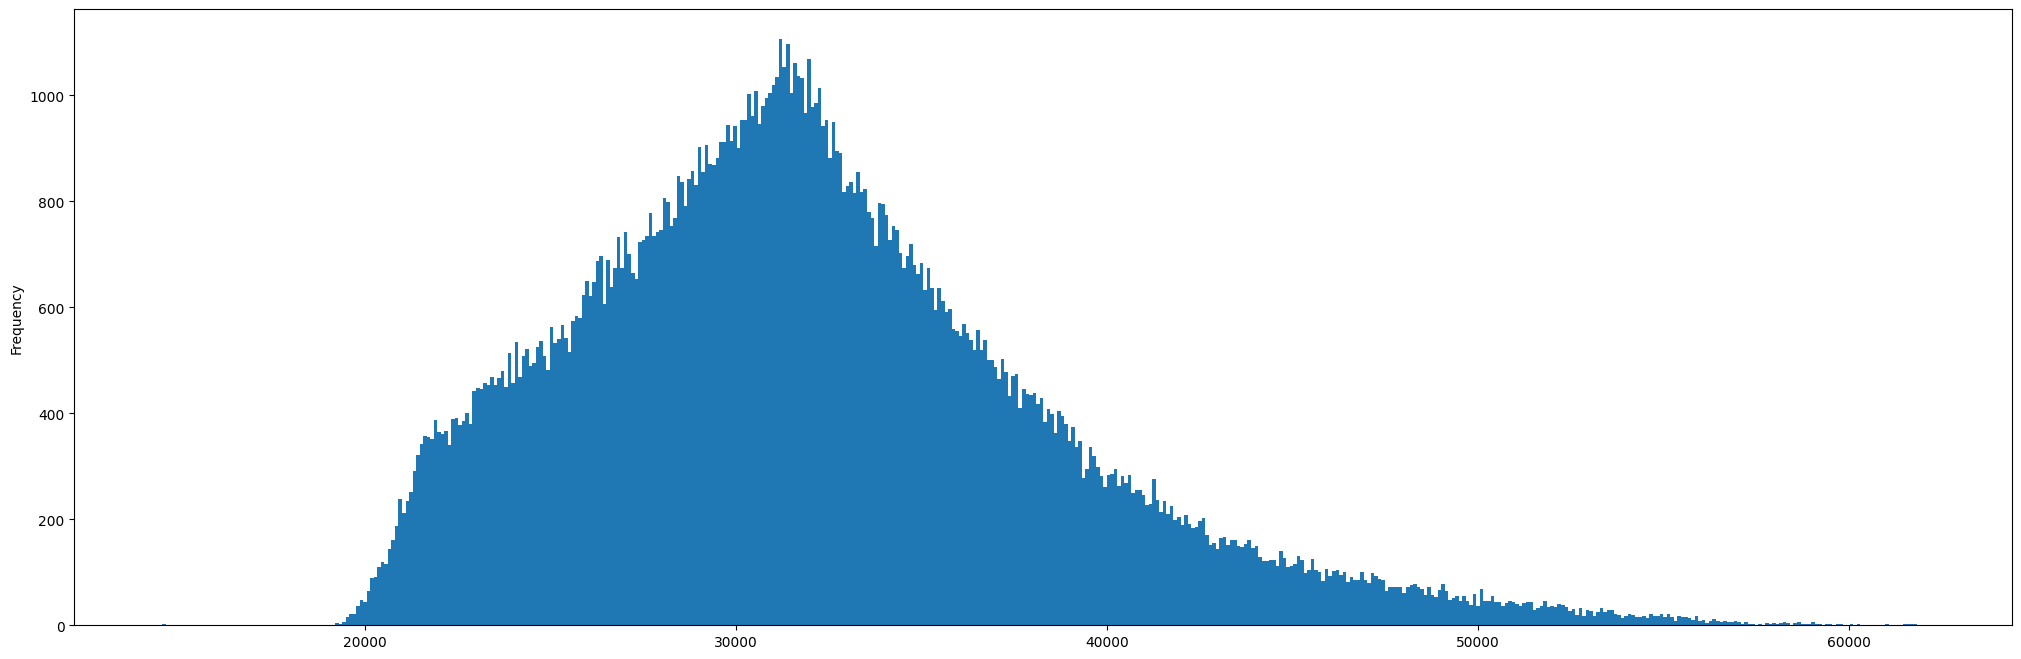

In [21]:
df['PJME_MW'].plot(kind='hist',bins=500,figsize=(25,8))

<Axes: xlabel='Datetime'>

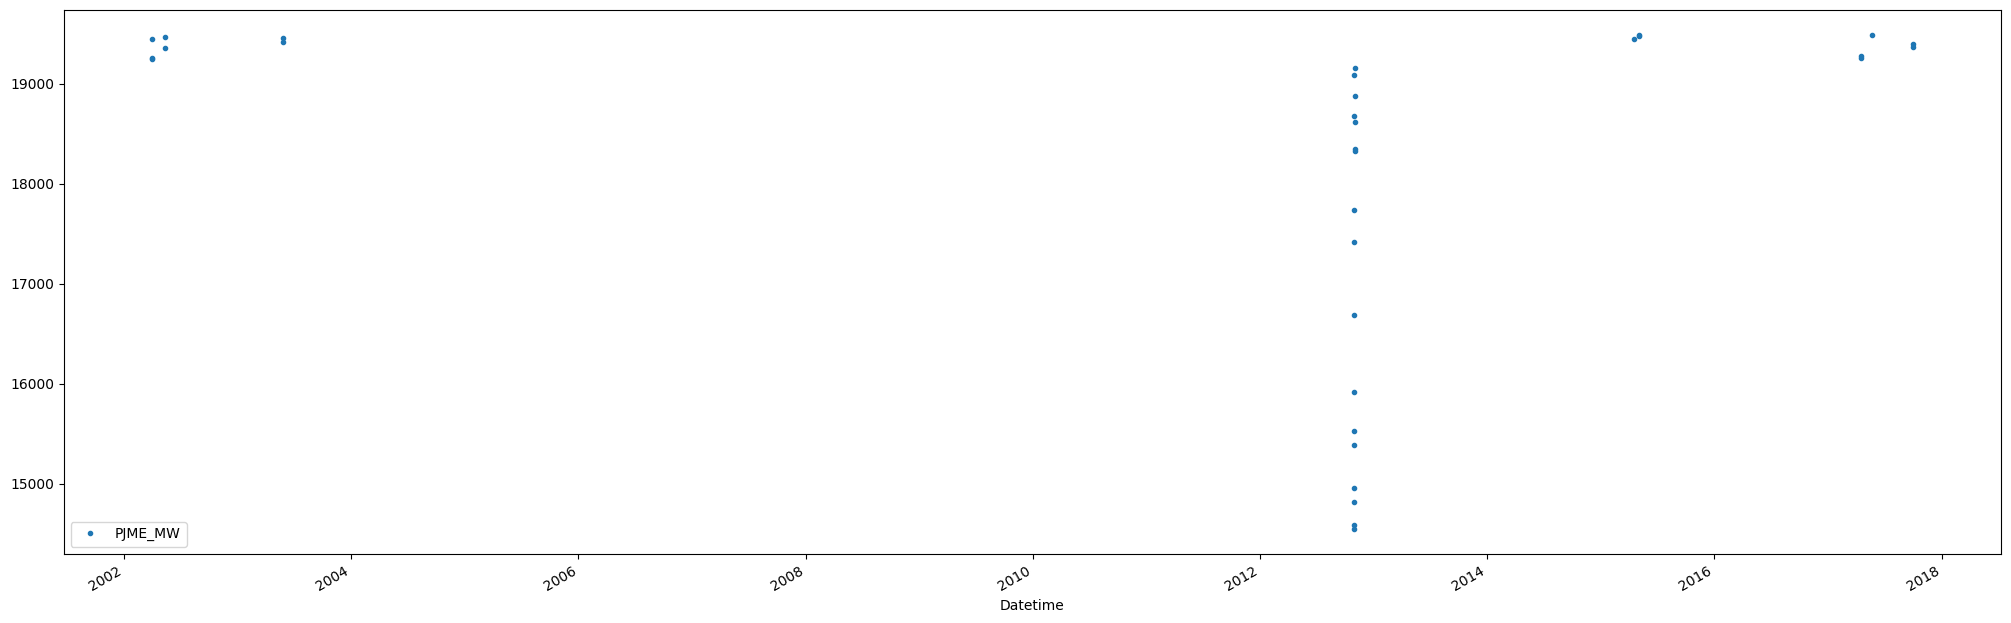

In [22]:
df.query('PJME_MW<19500').plot(figsize=(25,8),style='.')

In [23]:
df = df.query('PJME_MW>19500').copy()

<Axes: xlabel='Datetime'>

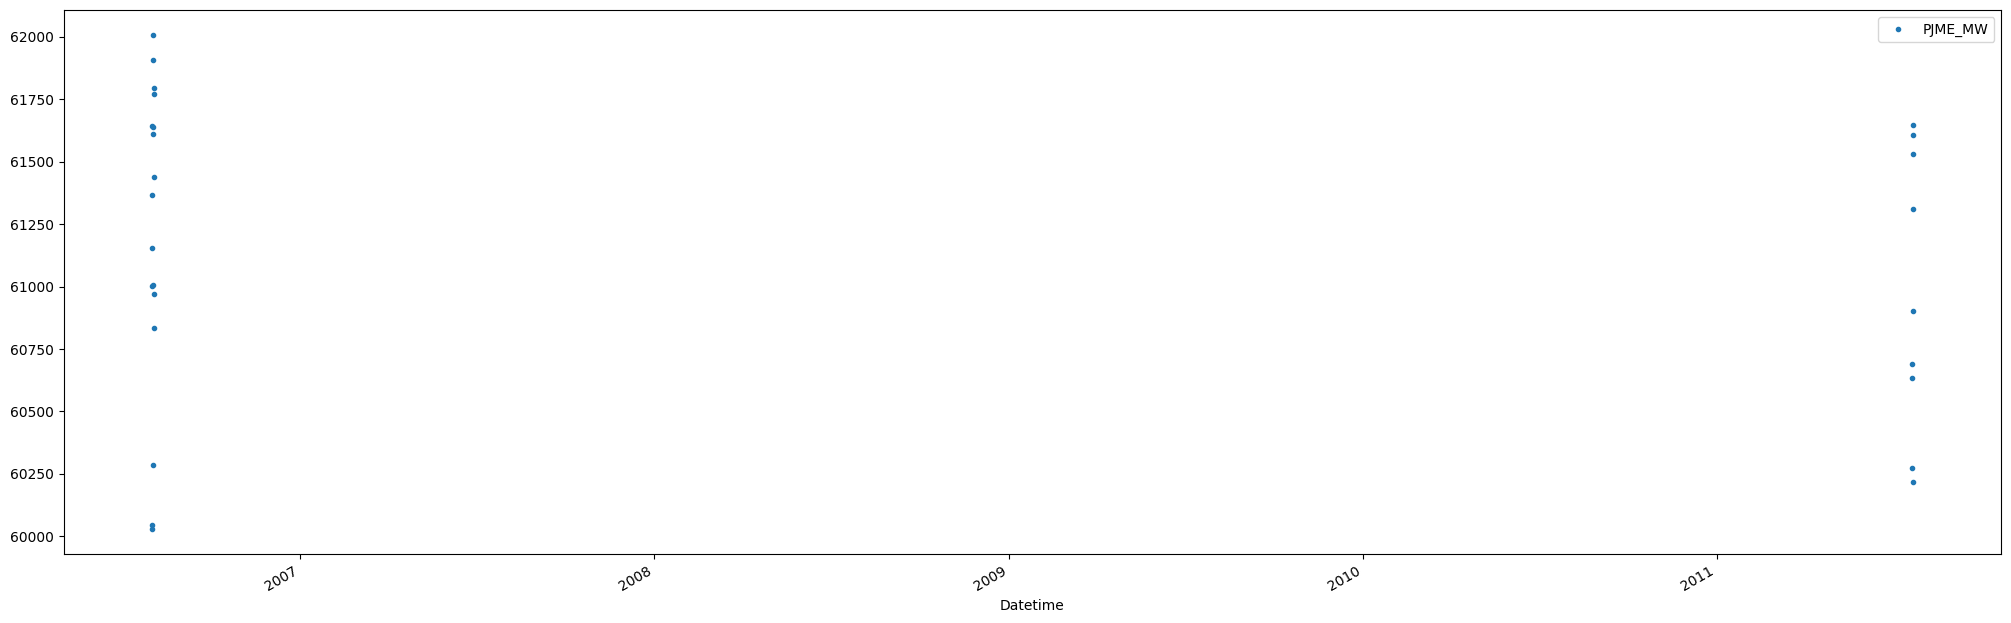

In [24]:
df.query('PJME_MW>60000').plot(figsize=(25,8),style='.')

In [25]:
df = df.query('PJME_MW<60000').copy()

In [26]:
df.shape

(145308, 1)

### Time Series Cross Validation (Train-Test-Split) (Advance) 

In [27]:
from sklearn.model_selection import TimeSeriesSplit

In [28]:
tss = TimeSeriesSplit(n_splits=5,test_size=24*365*1,gap=24) # test size of 1 year &  gap of 24hrs b/w train and test set
df = df.sort_index()

In [29]:
for train_idx, val_idx in tss.split(df):
    print(train_idx.shape,val_idx.shape)

(101484,) (8760,)
(110244,) (8760,)
(119004,) (8760,)
(127764,) (8760,)
(136524,) (8760,)


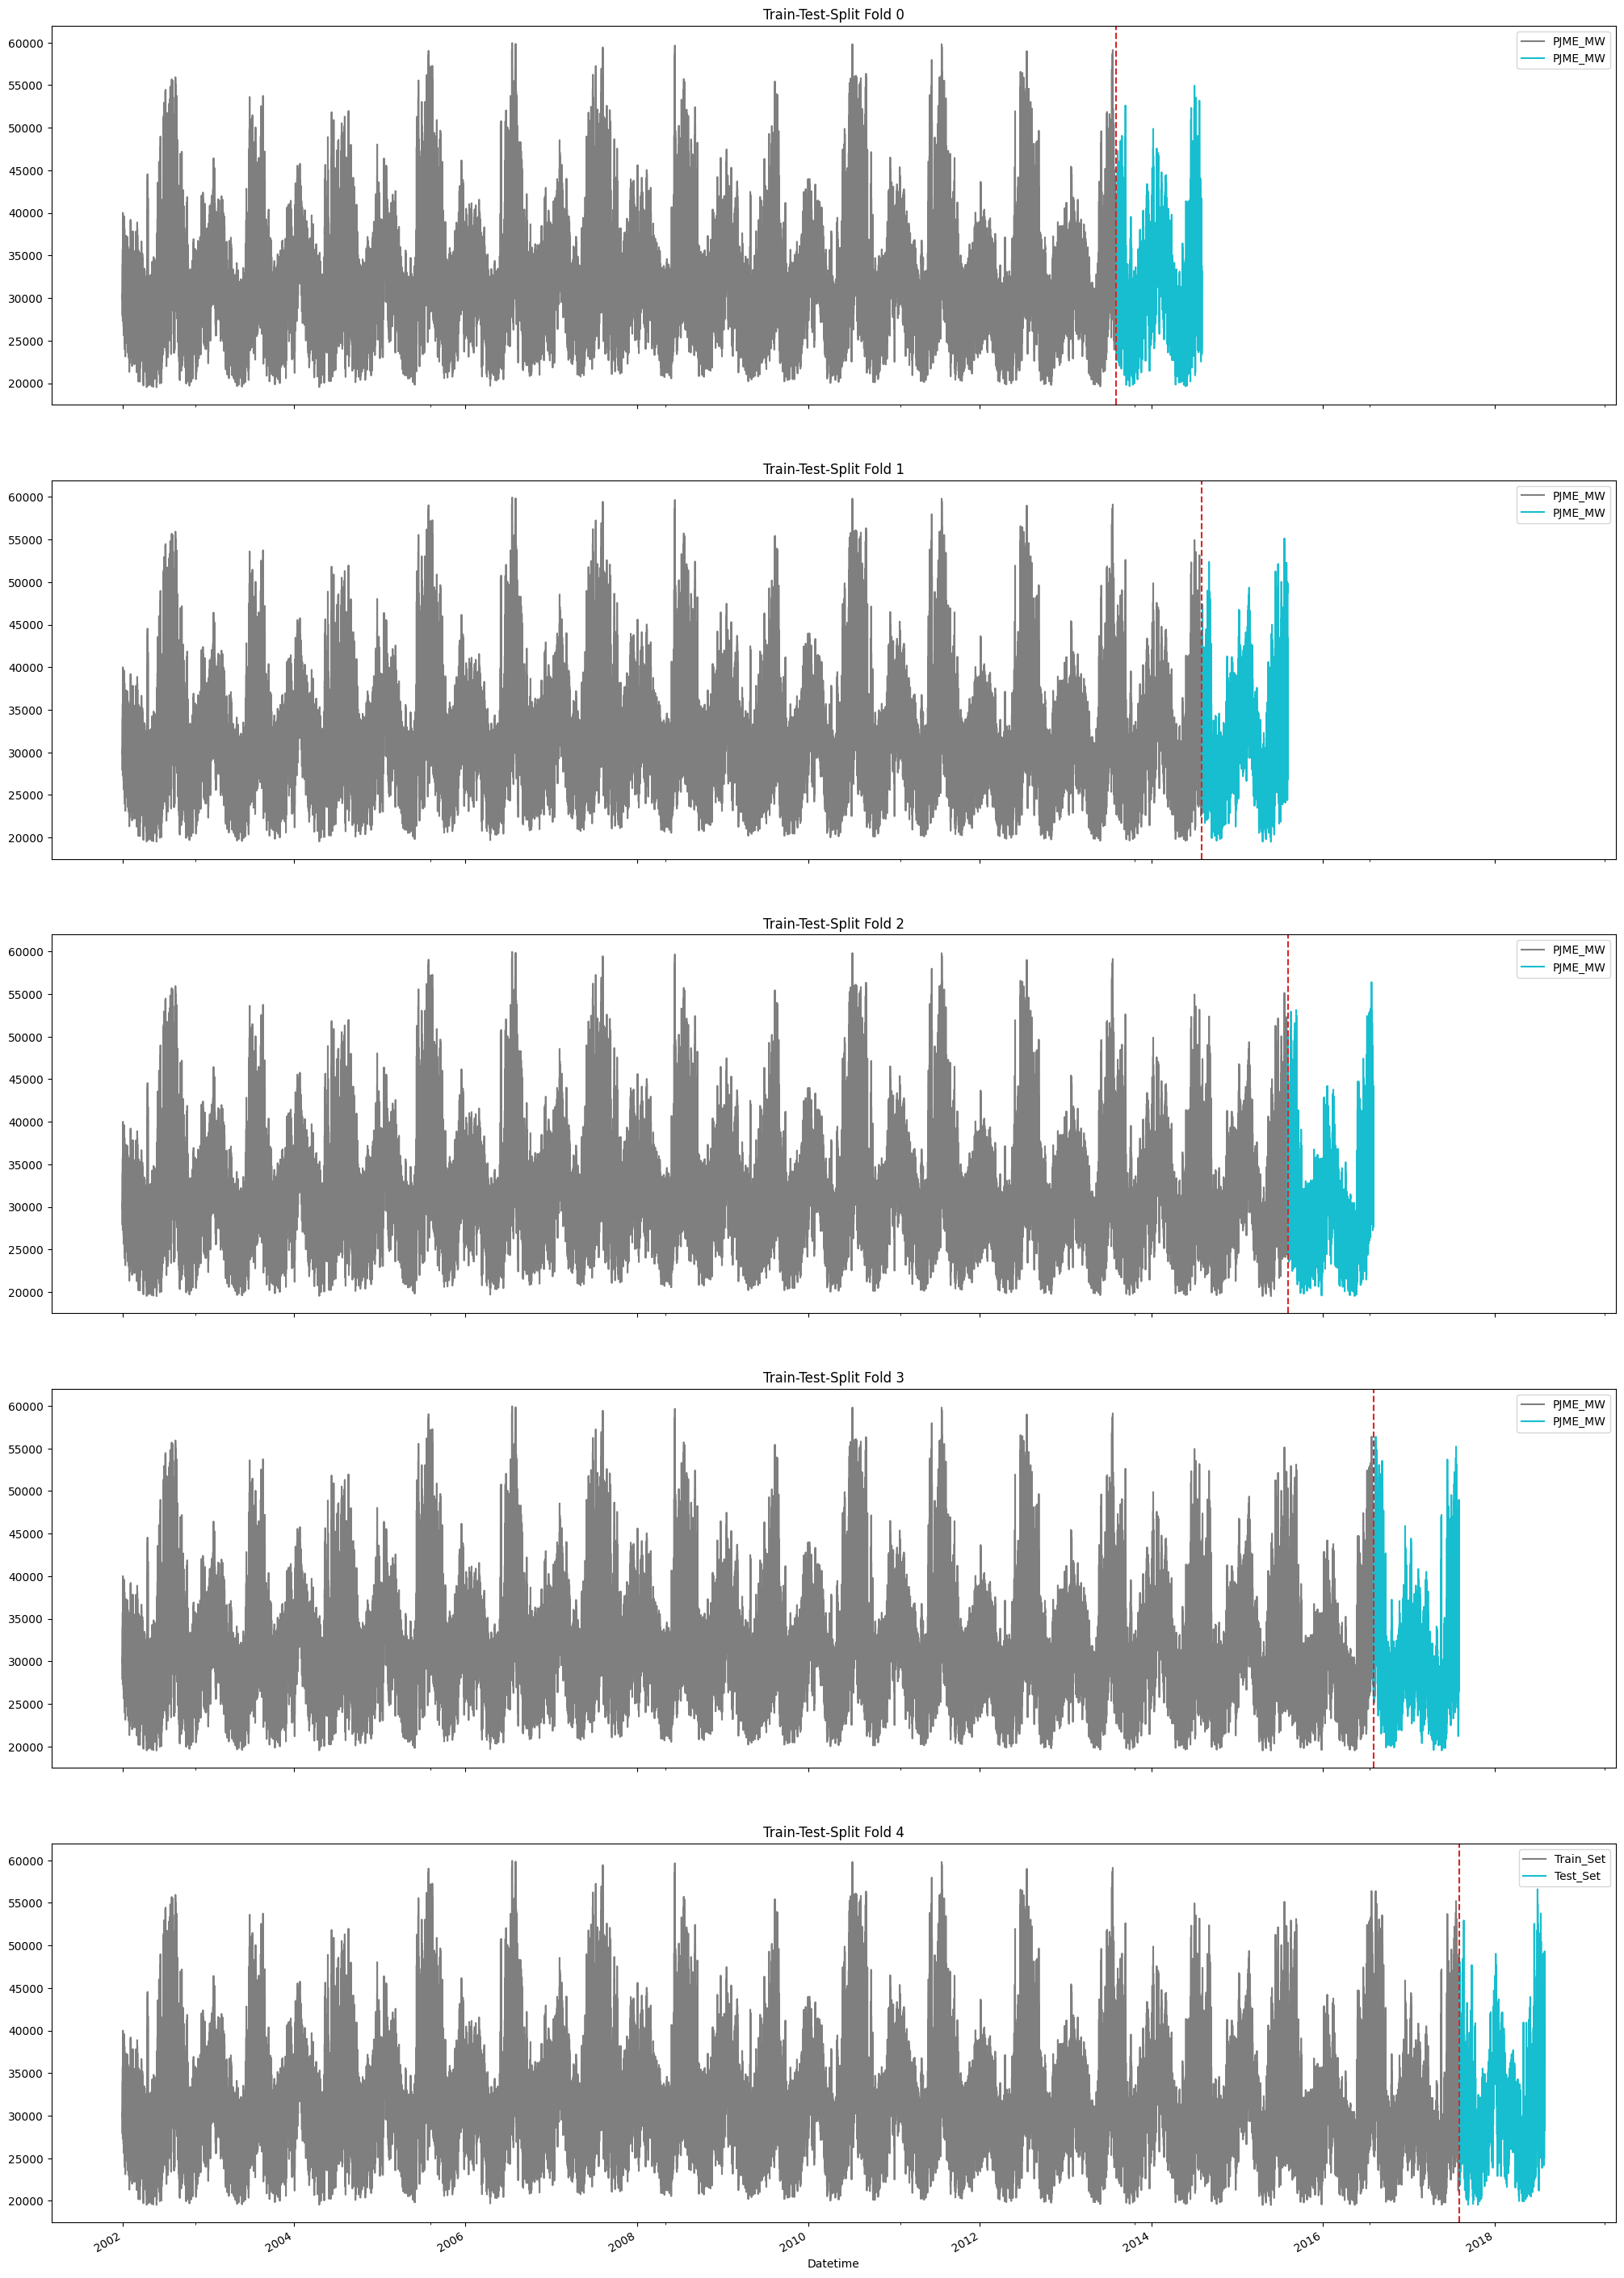

In [30]:
fig,ax = plt.subplots(5,1,figsize=(25,40),sharex=True)
fold=0
for train_idx,val_idx in tss.split(df):
    train =  df.iloc[train_idx]
    test = df.iloc[val_idx]
    train.plot(ax=ax[fold],label='Train Set',title=f"Train-Test-Split Fold {fold}",color=color_pal[7])
    test.plot(ax=ax[fold],label='Test Set',color=color_pal[9])
    ax[fold].axvline(test.index.min(),ls='--',color=color_pal[3])
    plt.legend(['Train_Set','Test_Set'])
    fold+=1

**``Forecasting Horizon``**``is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).``

### Feature Engineering

In [31]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week # monday == 0 & sunday ==6
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    return df

### Lag Features (Advance)

**``Lag Features``**``in time series forecasting are past values of the target variable (e.g., the value from one or more previous time steps) used as inputs to predict future values. They help capture temporal dependencies and patterns in the data.``

In [32]:
def add_lags(df):
    df = df.copy()
    target_map = df["PJME_MW"].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [33]:
df = add_lags(df)

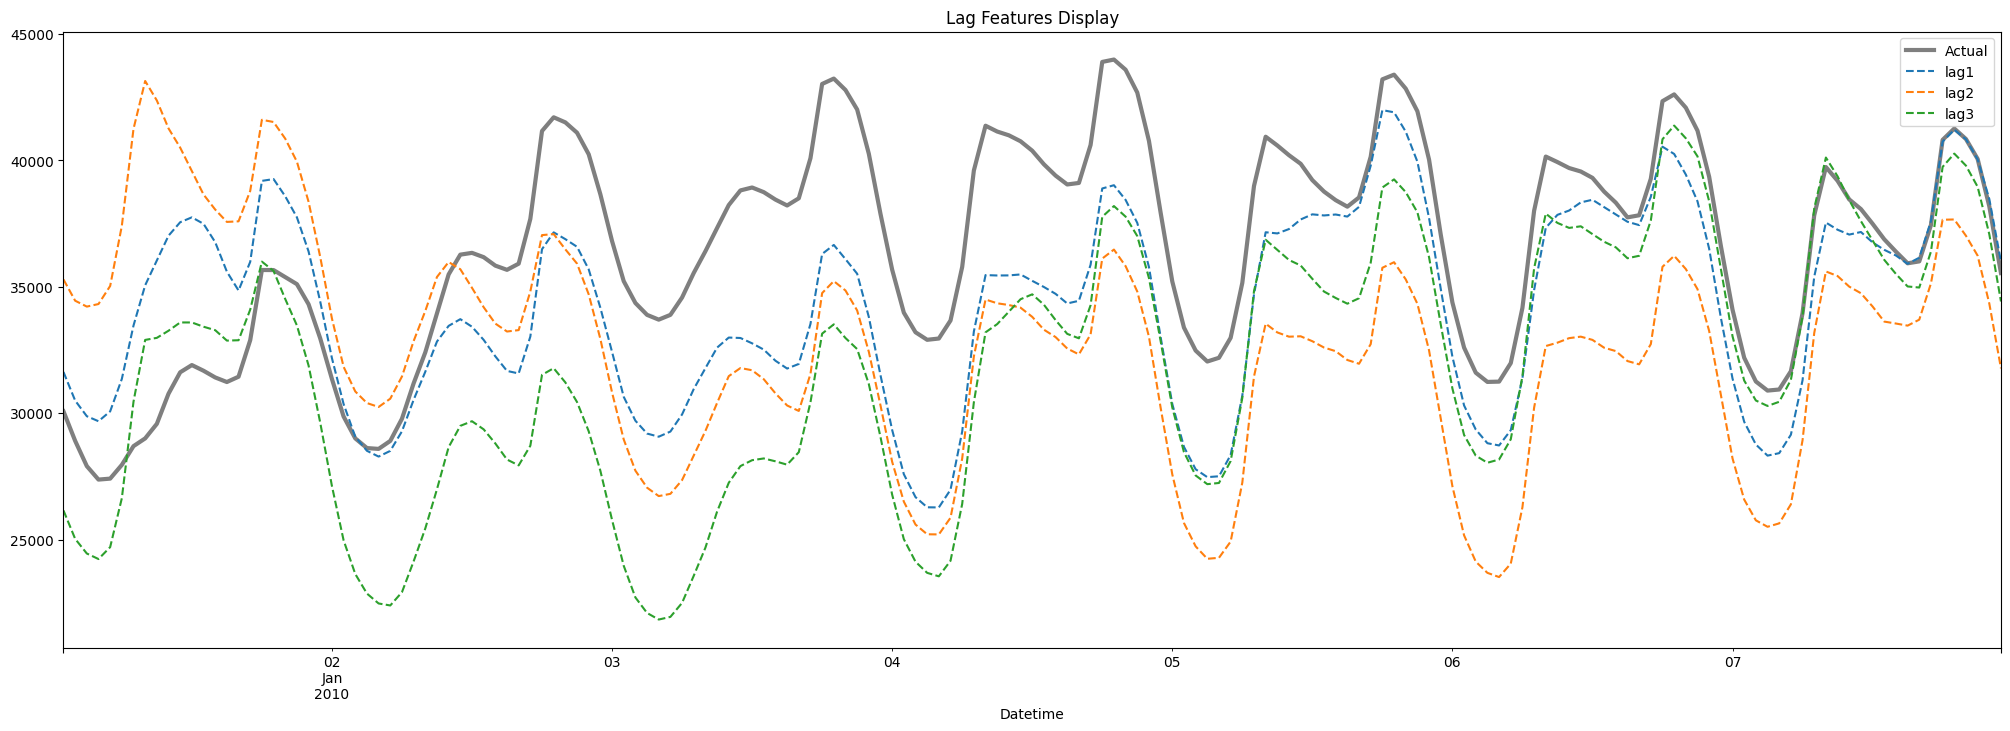

In [34]:
fig,ax = plt.subplots(figsize=(25,8))
df.loc[(df.index>'01-01-2010')&(df.index<'01-8-2010')]['PJME_MW'].plot(ax=ax,color=color_pal[7],linewidth=3)
df.loc[(df.index>'01-01-2010')&(df.index<'01-8-2010')]['lag1'].plot(ax=ax,color=color_pal[0],style='--')
df.loc[(df.index>'01-01-2010')&(df.index<'01-8-2010')]['lag2'].plot(ax=ax,color=color_pal[1],style='--')
df.loc[(df.index>'01-01-2010')&(df.index<'01-8-2010')]['lag3'].plot(ax=ax,color=color_pal[2],style='--')
plt.title("Lag Features Display")
plt.legend(['Actual','lag1','lag2','lag3'],loc='best')
plt.show()

### Model Training using Cross Validation (Advance)

In [37]:
fold = 0
scores = []
models = []
test_data = []
train_data = []
for train_idx,val_idx in tss.split(df): # train-test-split
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train = create_features(train)
    test = create_features(test)
    train = add_lags(train)
    test = add_lags(test)
    features = ['dayofyear','hour','dayofweek','quarter','month','year','lag1','lag2','lag3'] # feature-target-split
    target = 'PJME_MW'
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    reg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01) # model-creation
    reg.fit(X_train,y_train,
            eval_set=[(X_train,y_train),(X_test,y_test)],
            verbose=50) # model-training
    test['prediction'] = reg.predict(X_test)
    test_data.append(test)
    train_data.append(train)
    score = np.sqrt(mean_squared_error(y_test,test['prediction']))
    scores.append(score)
    models.append(reg)

[12:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32722.58198	validation_1-rmse:31972.64005
[50]	validation_0-rmse:20062.86452	validation_1-rmse:20013.67921
[100]	validation_0-rmse:12528.66549	validation_1-rmse:12908.49978
[150]	validation_0-rmse:8159.87730	validation_1-rmse:8933.01658
[200]	validation_0-rmse:5734.95354	validation_1-rmse:6810.22304
[250]	validation_0-rmse:4472.23704	validation_1-rmse:5663.50831
[300]	validation_0-rmse:3861.99174	validation_1-rmse:5034.97246
[350]	validation_0-rmse:3569.05776	validation_1-rmse:4725.12882
[400]	validation_0-rmse:3422.92903	validation_1-rmse:4519.55010
[450]	validation_0-rmse:3348.38559	validation_1-rmse:4341.37342
[500]	validation_0-rmse:3306.15551	validation_1-rmse:4334.58347
[524]	validation_0-rmse:3290.30352	validation_1-rmse:4352.3525

In [38]:
pd.DataFrame(data=scores,index=[0,1,2,3,4],columns=['scores'])

,scores
0,4314.856834
1,4344.676074
2,4051.844479
3,4391.648353
4,4506.230965


### Forecast on Test Dataset

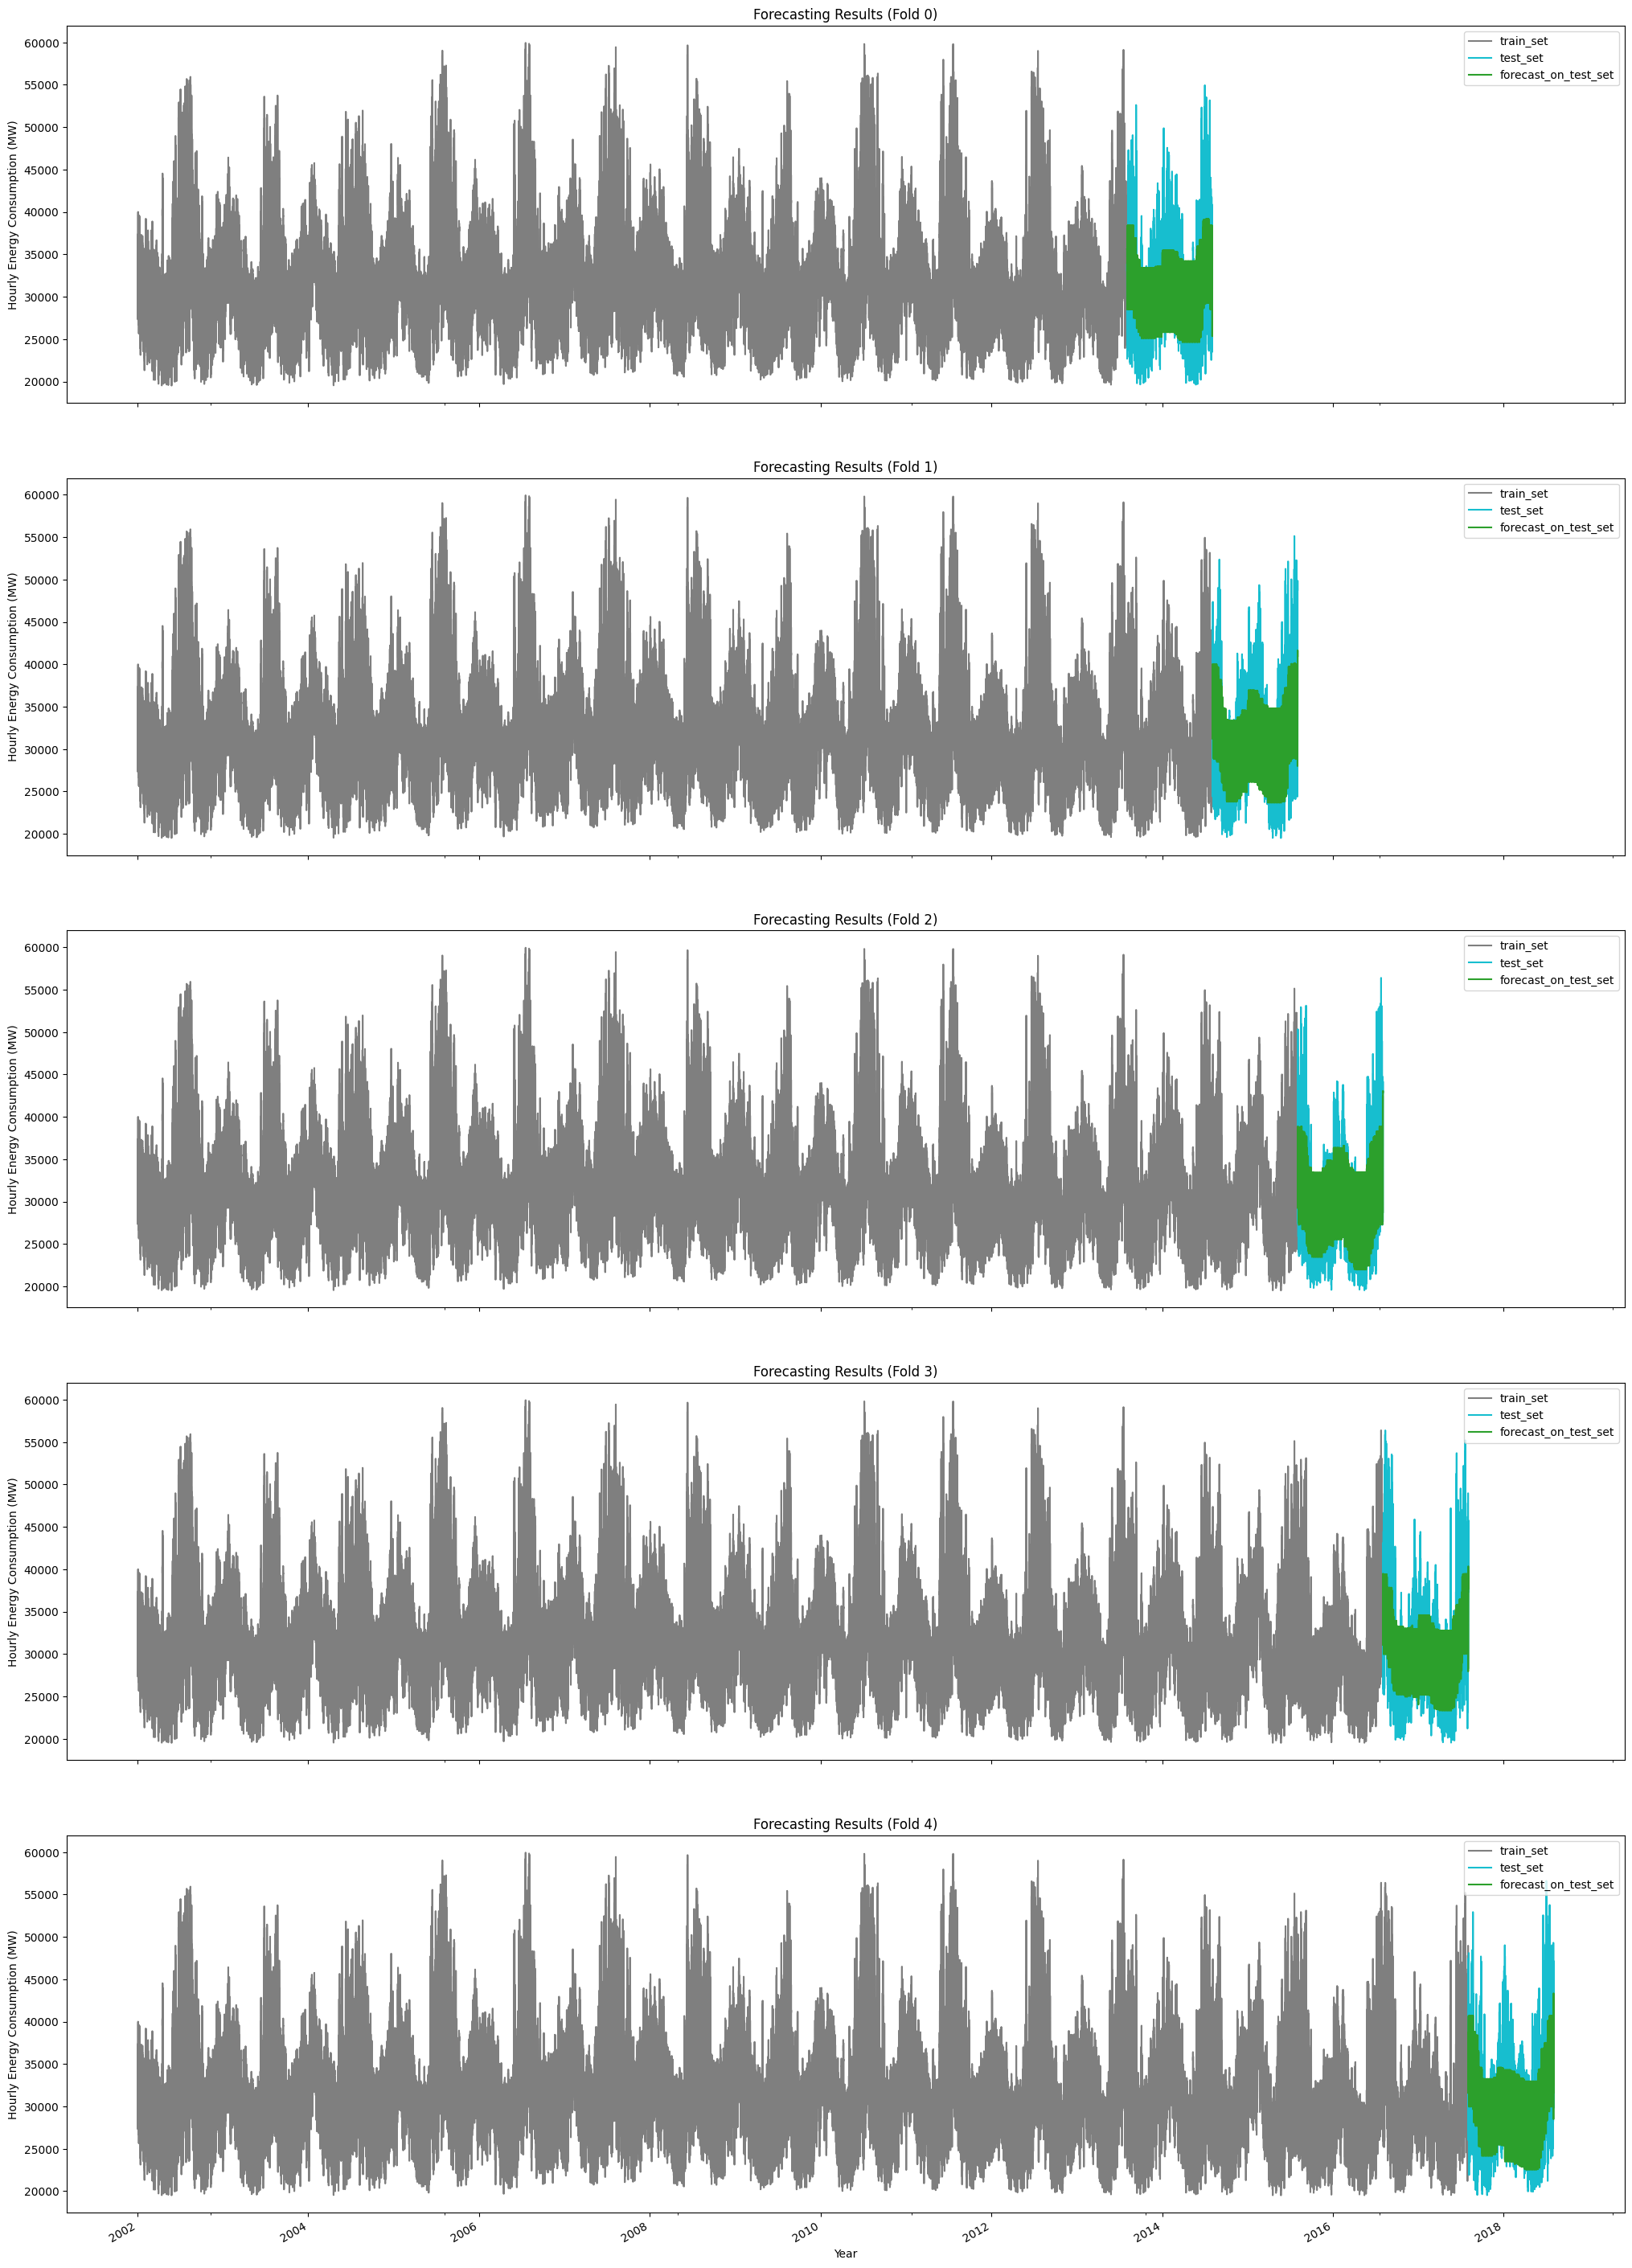

In [53]:
fig,ax = plt.subplots(5,1,figsize=(25,40),sharex=True)
fold=0
for train,test in zip(train_data,test_data):
    train['PJME_MW'].plot(ax=ax[fold],color=color_pal[7])
    test['PJME_MW'].plot(ax=ax[fold],color=color_pal[9])
    test['prediction'].plot(ax=ax[fold],color=color_pal[2])
    ax[fold].set_title(f"Forecasting Results (Fold {fold})")
    ax[fold].set_xlabel("Year")
    ax[fold].set_ylabel("Hourly Energy Consumption (MW)")
    ax[fold].legend(['train_set','test_set','forecast_on_test_set'],loc='best')
    fold+=1
plt.show()

### Future Forecast (Advance)

##### Retraining on all data

In [56]:
df = create_features(df)
df = add_lags(df)
features = ['dayofyear','hour','dayofweek','quarter','month','year','lag1','lag2','lag3']
target = 'PJME_MW'
X = df[features]
y = df[target]
reg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',
                           n_estimators=500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
reg.fit(X,y,eval_set=[(X,y)],verbose=100)

[19:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32397.90024
[100]	validation_0-rmse:12424.03259
[200]	validation_0-rmse:5750.91740
[300]	validation_0-rmse:3969.55421
[400]	validation_0-rmse:3568.63558
[499]	validation_0-rmse:3452.40355


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [59]:
df.head()

,PJME_MW,lag1,lag2,lag3,hour,dayofweek,dayofyear,dayofmonth,weekofyear,month,quarter,year
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,1,1,1,1,1,1,1,2002
2002-01-01 02:00:00,29265.0,NaN,NaN,NaN,2,1,1,1,1,1,1,2002
2002-01-01 03:00:00,28357.0,NaN,NaN,NaN,3,1,1,1,1,1,1,2002
2002-01-01 04:00:00,27899.0,NaN,NaN,NaN,4,1,1,1,1,1,1,2002
2002-01-01 05:00:00,28057.0,NaN,NaN,NaN,5,1,1,1,1,1,1,2002


##### Creating future dataframe

In [86]:
future = pd.date_range('2018-08-03','2020-08-01',freq='1h') # 2 years forecast
future_df = pd.DataFrame(index=future)
future_df['is_future'] = True
df['is_future'] = False
final_df = pd.concat([df,future_df],axis=0)

In [87]:
final_df.head()

,PJME_MW,lag1,lag2,lag3,hour,dayofweek,dayofyear,dayofmonth,weekofyear,month,quarter,year,is_future
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1,1.0,1.0,2002.0,False
2002-01-01 02:00:00,29265.0,NaN,NaN,NaN,2.0,1.0,1.0,1.0,1,1.0,1.0,2002.0,False
2002-01-01 03:00:00,28357.0,NaN,NaN,NaN,3.0,1.0,1.0,1.0,1,1.0,1.0,2002.0,False
2002-01-01 04:00:00,27899.0,NaN,NaN,NaN,4.0,1.0,1.0,1.0,1,1.0,1.0,2002.0,False
2002-01-01 05:00:00,28057.0,NaN,NaN,NaN,5.0,1.0,1.0,1.0,1,1.0,1.0,2002.0,False


In [88]:
final_df.tail()

,PJME_MW,lag1,lag2,lag3,hour,dayofweek,dayofyear,dayofmonth,weekofyear,month,quarter,year,is_future
2020-07-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2020-07-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2020-07-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2020-07-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2020-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True


##### Adding Feature Values and Lags

In [89]:
final_df = create_features(final_df)
final_df = add_lags(final_df)

In [90]:
final_df.tail()

,PJME_MW,lag1,lag2,lag3,hour,dayofweek,dayofyear,dayofmonth,weekofyear,month,quarter,year,is_future
2020-07-31 20:00:00,NaN,NaN,NaN,43606.0,20,4,213,31,31,7,3,2020,True
2020-07-31 21:00:00,NaN,NaN,NaN,41863.0,21,4,213,31,31,7,3,2020,True
2020-07-31 22:00:00,NaN,NaN,NaN,40005.0,22,4,213,31,31,7,3,2020,True
2020-07-31 23:00:00,NaN,NaN,NaN,37174.0,23,4,213,31,31,7,3,2020,True
2020-08-01 00:00:00,NaN,NaN,NaN,34310.0,0,5,214,1,31,8,3,2020,True


##### Forecast

In [91]:
predictions = reg.predict(final_df.loc[final_df['is_future']==True][features])

In [92]:
future_df['future_prediction'] = predictions

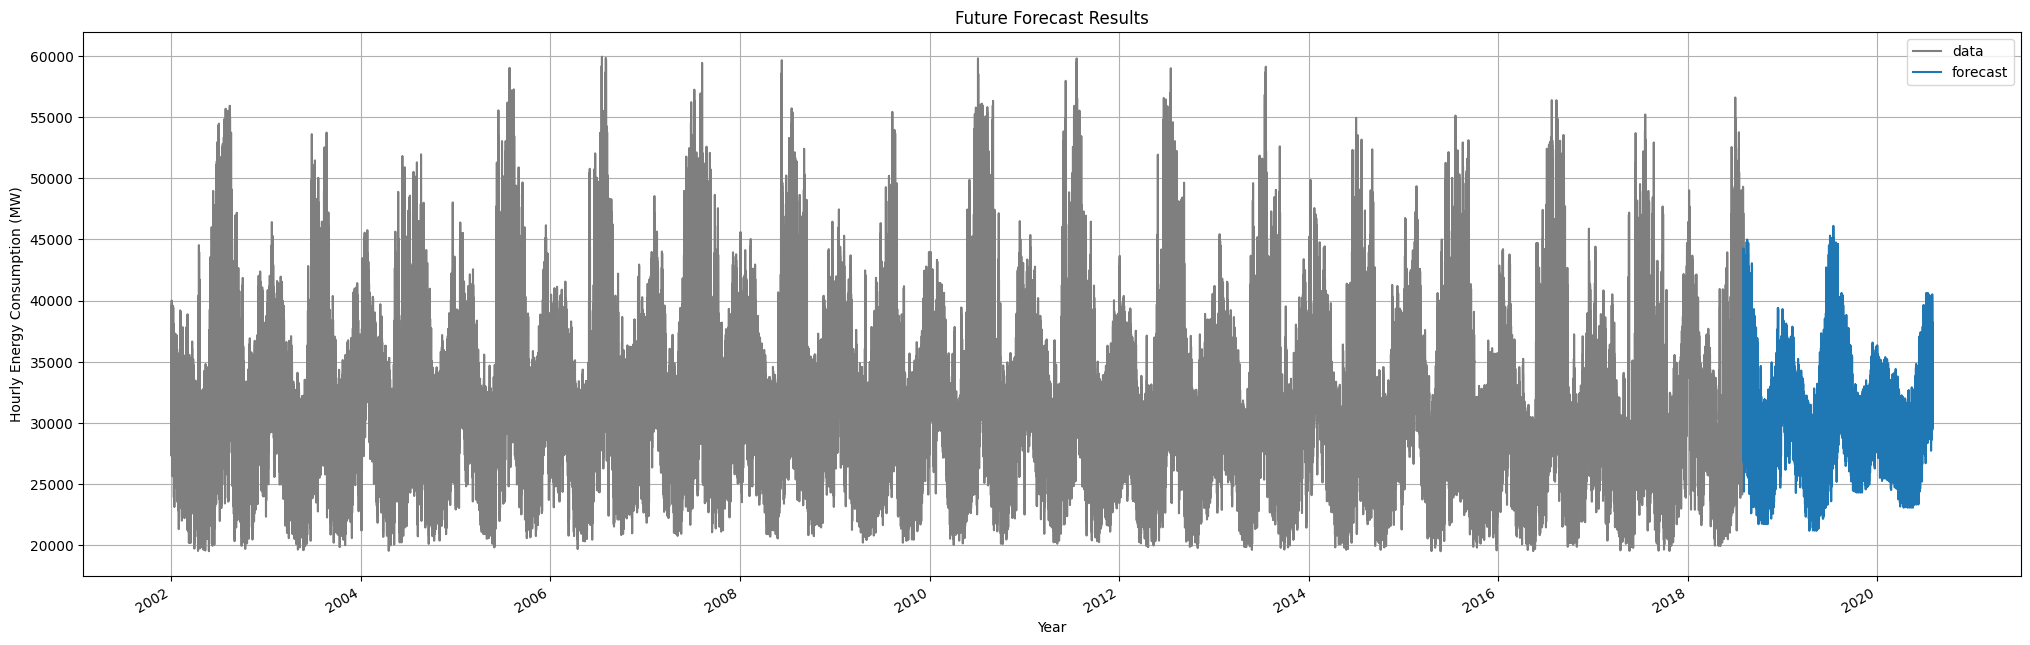

In [99]:
ax = df['PJME_MW'].plot(color=color_pal[7],figsize=(25,8))
future_df['future_prediction'].plot(ax=ax,color=color_pal[0])
plt.title(f"Future Forecast Results")
plt.xlabel("Year")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.legend(['data','forecast'],loc='best')
plt.grid()
plt.show()

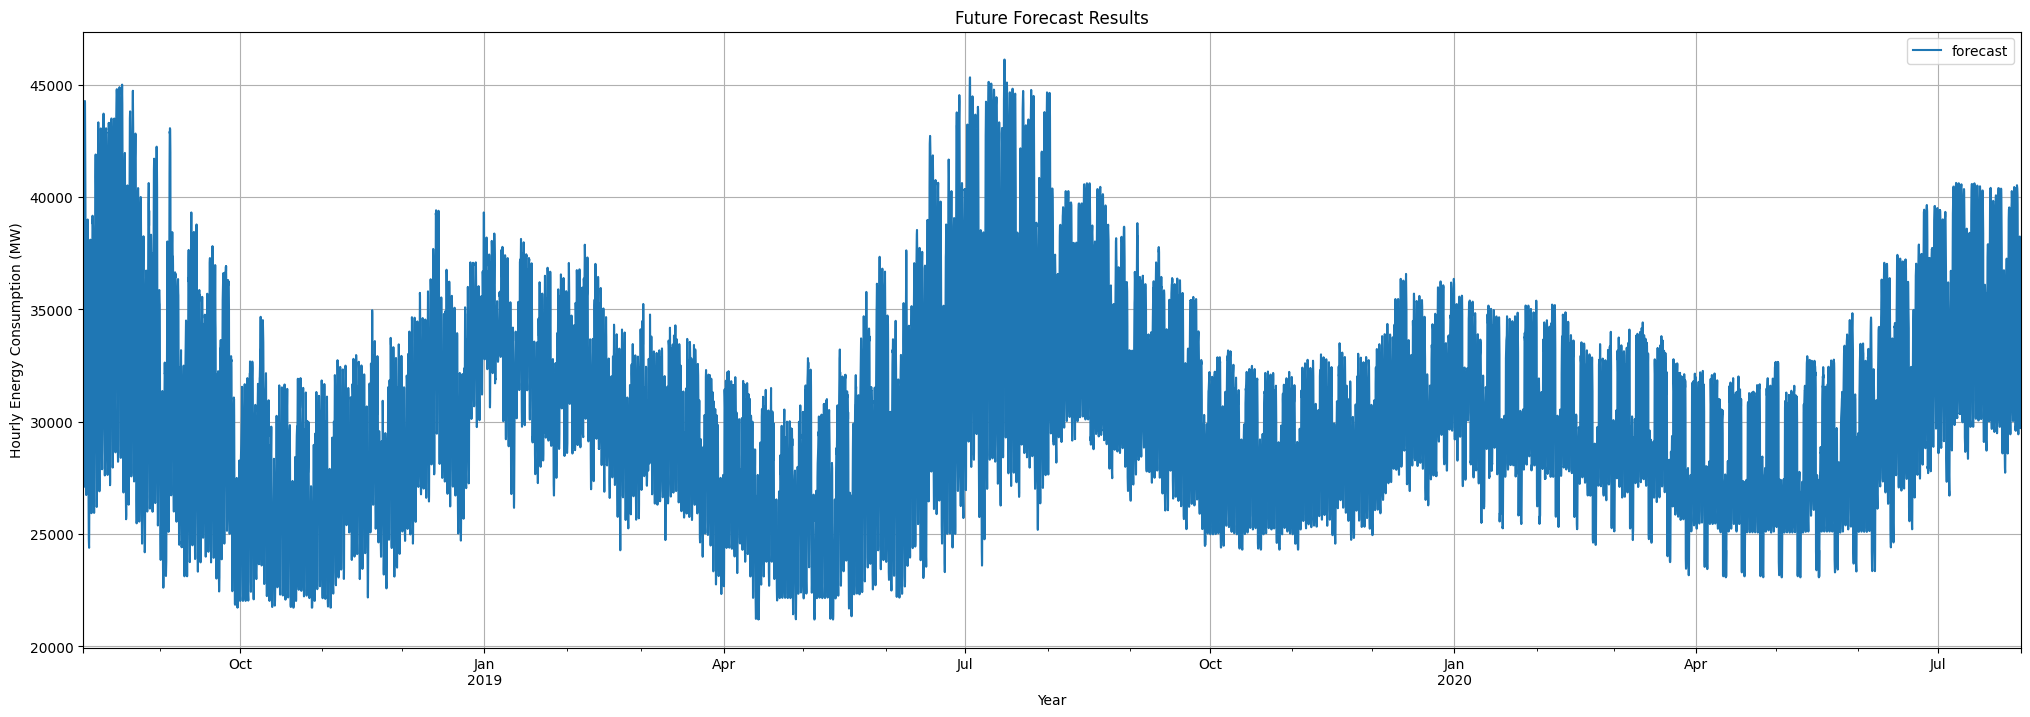

In [101]:
future_df['future_prediction'].plot(figsize=(25,8),color=color_pal[0])
plt.title(f"Future Forecast Results")
plt.xlabel("Year")
plt.ylabel("Hourly Energy Consumption (MW)")
plt.legend(['forecast'],loc='best')
plt.grid()
plt.show()

### Saving Model

In [103]:
reg.save_model("model.p")